In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [58]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [59]:
bs = 32

In [263]:
# Load Data
dataset = datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(1000, 32)

In [264]:
for idx, (images, _) in enumerate(dataloader):
    print(images.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([8, 3, 64, 64])


torch.Size([32, 3, 64, 64])


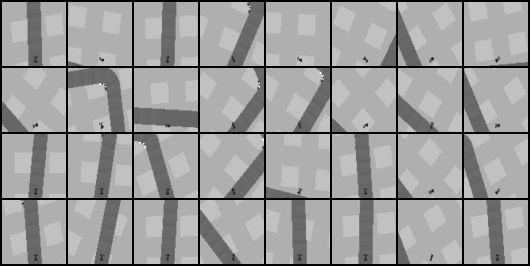

In [265]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
print(fixed_x.shape)
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [62]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [63]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [292]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [293]:
image_channels = fixed_x.size(1)

In [294]:
vae = VAE(image_channels=image_channels).to(device)

In [295]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 

In [296]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [297]:
!rm -rfr reconstructed
!mkdir reconstructed

In [298]:
epochs = 100

In [ ]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data/bs, bce.data/bs, kld.data/bs)
        print(to_print)


torch.save(vae.state_dict(), 'vae.torch')

Epoch[1/100] Loss: 8523.478 8523.478 0.000
Epoch[1/100] Loss: 8509.838 8509.838 0.000
Epoch[1/100] Loss: 8477.853 8477.853 0.000
Epoch[1/100] Loss: 8394.636 8394.636 0.000
Epoch[1/100] Loss: 8301.640 8301.638 0.002
Epoch[1/100] Loss: 8546.343 8546.331 0.012
Epoch[1/100] Loss: 8249.786 8249.783 0.003
Epoch[1/100] Loss: 8255.282 8255.281 0.001
Epoch[1/100] Loss: 8283.188 8283.188 0.000
Epoch[1/100] Loss: 8303.188 8303.188 0.000
Epoch[1/100] Loss: 8296.847 8296.847 0.000
Epoch[1/100] Loss: 8254.137 8254.137 0.000
Epoch[1/100] Loss: 8203.142 8203.142 0.000
Epoch[1/100] Loss: 8137.819 8137.819 0.000
Epoch[1/100] Loss: 8193.522 8193.522 0.000
Epoch[1/100] Loss: 8201.215 8201.215 0.000
Epoch[1/100] Loss: 8285.656 8285.656 0.000
Epoch[1/100] Loss: 8109.222 8109.222 0.000
Epoch[1/100] Loss: 8117.176 8117.176 0.000
Epoch[1/100] Loss: 8103.197 8103.197 0.000
Epoch[1/100] Loss: 8038.080 8038.080 0.000
Epoch[1/100] Loss: 8043.254 8043.254 0.000
Epoch[1/100] Loss: 7971.959 7971.959 0.000
Epoch[1/100

Epoch[7/100] Loss: 7749.882 7749.818 0.064
Epoch[7/100] Loss: 7817.280 7817.216 0.064
Epoch[7/100] Loss: 7720.736 7720.671 0.064
Epoch[7/100] Loss: 7760.736 7760.678 0.058
Epoch[7/100] Loss: 7742.923 7742.861 0.062
Epoch[7/100] Loss: 7773.968 7773.902 0.067
Epoch[7/100] Loss: 7735.702 7735.635 0.067
Epoch[7/100] Loss: 7702.517 7702.452 0.066
Epoch[7/100] Loss: 7716.895 7716.824 0.070
Epoch[7/100] Loss: 7710.057 7709.976 0.081
Epoch[7/100] Loss: 7736.370 7736.316 0.054
Epoch[7/100] Loss: 7710.513 7710.445 0.068
Epoch[7/100] Loss: 7758.149 7758.072 0.077
Epoch[7/100] Loss: 7722.399 7722.325 0.075
Epoch[7/100] Loss: 7736.405 7736.341 0.064
Epoch[7/100] Loss: 7737.590 7737.522 0.068
Epoch[7/100] Loss: 7774.922 7774.844 0.078
Epoch[7/100] Loss: 7733.115 7733.043 0.072
Epoch[7/100] Loss: 7743.059 7742.983 0.075
Epoch[7/100] Loss: 7737.026 7736.949 0.077
Epoch[7/100] Loss: 7748.064 7747.971 0.093
Epoch[7/100] Loss: 7699.863 7699.791 0.072
Epoch[7/100] Loss: 7720.822 7720.743 0.079
Epoch[7/100

Epoch[12/100] Loss: 7654.105 7654.001 0.104
Epoch[12/100] Loss: 1907.003 1906.879 0.125
Epoch[13/100] Loss: 7653.112 7653.019 0.094
Epoch[13/100] Loss: 7634.400 7634.276 0.124
Epoch[13/100] Loss: 7655.873 7655.750 0.123
Epoch[13/100] Loss: 7650.206 7650.094 0.112
Epoch[13/100] Loss: 7645.334 7645.214 0.120
Epoch[13/100] Loss: 7628.563 7628.441 0.123
Epoch[13/100] Loss: 7699.352 7699.231 0.120
Epoch[13/100] Loss: 7648.109 7648.000 0.109
Epoch[13/100] Loss: 7667.234 7667.108 0.126
Epoch[13/100] Loss: 7667.625 7667.507 0.118
Epoch[13/100] Loss: 7656.841 7656.732 0.110
Epoch[13/100] Loss: 7654.355 7654.253 0.102
Epoch[13/100] Loss: 7638.779 7638.664 0.115
Epoch[13/100] Loss: 7662.515 7662.385 0.130
Epoch[13/100] Loss: 7700.481 7700.370 0.111
Epoch[13/100] Loss: 7663.988 7663.867 0.121
Epoch[13/100] Loss: 7709.408 7709.299 0.109
Epoch[13/100] Loss: 7663.531 7663.419 0.112
Epoch[13/100] Loss: 7681.394 7681.296 0.097
Epoch[13/100] Loss: 7673.037 7672.954 0.083
Epoch[13/100] Loss: 7677.019 767

Epoch[18/100] Loss: 7639.458 7639.352 0.106
Epoch[18/100] Loss: 7622.146 7622.035 0.112
Epoch[18/100] Loss: 7625.196 7625.082 0.114
Epoch[18/100] Loss: 7660.691 7660.585 0.105
Epoch[18/100] Loss: 7644.489 7644.383 0.106
Epoch[18/100] Loss: 7634.995 7634.881 0.114
Epoch[18/100] Loss: 1913.715 1913.617 0.098
Epoch[19/100] Loss: 7647.486 7647.386 0.100
Epoch[19/100] Loss: 7644.883 7644.775 0.108
Epoch[19/100] Loss: 7642.688 7642.571 0.116
Epoch[19/100] Loss: 7649.155 7649.053 0.102
Epoch[19/100] Loss: 7640.479 7640.370 0.109
Epoch[19/100] Loss: 7608.626 7608.500 0.127
Epoch[19/100] Loss: 7653.159 7653.050 0.109
Epoch[19/100] Loss: 7659.690 7659.587 0.103
Epoch[19/100] Loss: 7635.979 7635.862 0.116
Epoch[19/100] Loss: 7646.098 7645.978 0.121
Epoch[19/100] Loss: 7612.327 7612.213 0.114
Epoch[19/100] Loss: 7638.671 7638.564 0.107
Epoch[19/100] Loss: 7635.726 7635.603 0.123
Epoch[19/100] Loss: 7652.000 7651.888 0.113
Epoch[19/100] Loss: 7610.623 7610.502 0.120
Epoch[19/100] Loss: 7647.509 764

Epoch[24/100] Loss: 7622.355 7622.232 0.123
Epoch[24/100] Loss: 7644.362 7644.247 0.115
Epoch[24/100] Loss: 7629.463 7629.329 0.134
Epoch[24/100] Loss: 7601.839 7601.701 0.138
Epoch[24/100] Loss: 7623.974 7623.854 0.120
Epoch[24/100] Loss: 7606.509 7606.373 0.136
Epoch[24/100] Loss: 7621.509 7621.391 0.118
Epoch[24/100] Loss: 7634.468 7634.350 0.118
Epoch[24/100] Loss: 7626.912 7626.779 0.132
Epoch[24/100] Loss: 7634.507 7634.381 0.126
Epoch[24/100] Loss: 7641.013 7640.895 0.118
Epoch[24/100] Loss: 1899.893 1899.780 0.113
Epoch[25/100] Loss: 7634.947 7634.824 0.123
Epoch[25/100] Loss: 7618.481 7618.354 0.127
Epoch[25/100] Loss: 7621.962 7621.837 0.124
Epoch[25/100] Loss: 7625.868 7625.750 0.117
Epoch[25/100] Loss: 7640.907 7640.782 0.125
Epoch[25/100] Loss: 7637.372 7637.246 0.126
Epoch[25/100] Loss: 7610.646 7610.514 0.132
Epoch[25/100] Loss: 7639.385 7639.265 0.120
Epoch[25/100] Loss: 7617.153 7617.023 0.130
Epoch[25/100] Loss: 7635.439 7635.318 0.121
Epoch[25/100] Loss: 7633.493 763

Epoch[30/100] Loss: 7621.242 7621.115 0.127
Epoch[30/100] Loss: 7617.500 7617.375 0.125
Epoch[30/100] Loss: 7622.135 7622.009 0.126
Epoch[30/100] Loss: 7619.433 7619.307 0.126
Epoch[30/100] Loss: 7611.788 7611.665 0.122
Epoch[30/100] Loss: 7644.964 7644.853 0.111
Epoch[30/100] Loss: 7645.831 7645.714 0.117
Epoch[30/100] Loss: 7614.506 7614.375 0.131
Epoch[30/100] Loss: 7602.693 7602.569 0.124
Epoch[30/100] Loss: 7621.652 7621.536 0.116
Epoch[30/100] Loss: 7615.759 7615.640 0.119
Epoch[30/100] Loss: 7623.030 7622.908 0.122
Epoch[30/100] Loss: 7627.542 7627.424 0.118
Epoch[30/100] Loss: 7628.046 7627.929 0.117
Epoch[30/100] Loss: 7626.749 7626.630 0.118
Epoch[30/100] Loss: 7599.459 7599.333 0.127
Epoch[30/100] Loss: 1904.760 1904.645 0.115
Epoch[31/100] Loss: 7624.751 7624.625 0.126
Epoch[31/100] Loss: 7615.585 7615.458 0.127
Epoch[31/100] Loss: 7609.046 7608.922 0.125
Epoch[31/100] Loss: 7612.308 7612.176 0.131
Epoch[31/100] Loss: 7617.717 7617.595 0.122
Epoch[31/100] Loss: 7618.306 761

In [ ]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

torch.Size([1, 3, 64, 64])


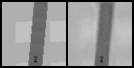

In [291]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
print(fixed_x.shape)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

z, mu, logvar = vae.encode(fixed_x)

In [277]:
print(fixed_x)

tensor([[[[0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          ...,
          [0.7569, 0.7569, 0.7569,  ..., 0.7569, 0.7569, 0.7569],
          [0.7569, 0.7569, 0.7569,  ..., 0.7569, 0.7569, 0.7569],
          [0.7569, 0.7569, 0.7569,  ..., 0.7569, 0.7569, 0.7569]],

         [[0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          ...,
          [0.7569, 0.7569, 0.7569,  ..., 0.7569, 0.7569, 0.7569],
          [0.7569, 0.7569, 0.7569,  ..., 0.7569, 0.7569, 0.7569],
          [0.7569, 0.7569, 0.7569,  ..., 0.7569, 0.7569, 0.7569]],

         [[0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0